## Import dependencies

In [24]:
pip install tensorflow

^C
Note: you may need to restart the kernel to use updated packages.


In [2]:
import mediapipe as mp
import numpy as np
import cv2 as cv2
import os
from matplotlib import pyplot as plt
import time

## Keypoints using MP Holistic

In [3]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [5]:
def draw_styled_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color = (51,255,255), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color = (153,0,76), thickness=1, circle_radius=2))
    mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color = (51,102,0), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color = (102,78,255), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image,results.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color = (102,0,204), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color = (255,255,102), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image,results.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color = (102,0,204), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color = (255,255,102), thickness=2, circle_radius=2))

In [6]:
cap = cv2.VideoCapture(0);
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5 ) as holistic:
    while cap.isOpened():
        ret,frame = cap.read()
        image, results = mediapipe_detection(frame,holistic)
#         print(results)
        draw_styled_landmarks(image,results)
        cv2.imshow('OpenCv Window',image)
        if cv2.waitKey(10) & 0xff == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [7]:
draw_styled_landmarks(frame,results) 

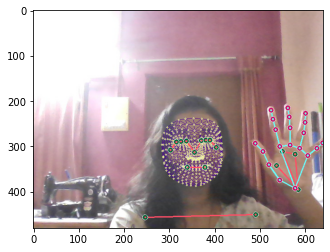

In [8]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [9]:
# img = cv2.imread("img.jpg")

In [10]:
# with mp_holistic.Holistic(static_image_mode=True) as holistic :
#     result = holistic.process(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
#     print('NOSE world landmarks : ')
#     print(result.pose_world_landmarks.landmark[mp_holistic.PoseLandmark.NOSE])
    
# #     Plot pose world landmarks
#     mp_drawing.plot_landmarks(
#     result.pose_world_landmarks,mp_holistic.POSE_CONNECTIONS)

## Extract key value points

In [11]:
def extract_keypoints(results):
    pose = np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(1404)
    face = np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(63) 
    lh = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(63)
    rh = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(63) 
    return np.concatenate([pose,face,lh,rh])

In [12]:
result_test = extract_keypoints(results)

## Setup Folders for Collection

In [13]:
DATA_PATH = os.path.join('MP_DATA')
actions = np.array(['hello','thanks','iloveyou'])
no_seq = 30
seq_len = 30

In [14]:
for action in actions :
    for sequence in range(no_seq) :
        try :
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except :
            pass

## Collect Keypoints values for training and testing

In [15]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5 ) as holistic:
    
    # NEW LOOP through actions
    for action in actions :
        for sequence in range(no_seq) :
            for frame_num in range(seq_len) :
                ret,frame = cap.read()
                image, results = mediapipe_detection(frame,holistic)
                # print(results)
                draw_styled_landmarks(image,results)
                
                # New "Apply wait" logic
                if frame_num == 0 :
                    cv2.putText(image, 'STARTING COLLECTION',(120,200),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),1,cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video number {}'.format(action,sequence),(15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255),1,cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCv Window',image)
                    cv2.waitKey(2000)
                else :
                    cv2.putText(image, 'Collecting frames for {} Video number {}'.format(action,sequence),(15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255),1,cv2.LINE_AA)
                     # Show to screen
                    cv2.imshow('OpenCv Window',image)
                    
                # NEW EXPORT keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence),str(frame_num))
                np.save(npy_path, keypoints)
                
                if cv2.waitKey(10) & 0xff == ord('q'):
                    break
        
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [20]:
np.load(r'C:\Users\Nida Shaikh\JuPyNB\SemV_MP\MP_DATA\hello\15\15.npy')

array([ 0.57089823,  0.56072694, -0.91530228, ...,  0.33791426,
        0.28670764, -0.05266859])

## Preprocess data and create labels

In [25]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical